# Classify emotions in text with BERT NLP model 

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [4]:
!pip install transformers

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
# % matplotlib inline

In [6]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [7]:
device = torch.device("cuda")

BertTokenizer to run end-to-end tokenization: punctuation splitting + word piece. 
BertForSequenceClassification is the Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output). 
BertConfig is the configuration class to store model configurations. 
AdamW implements Adam learning rate optimization algorithm, it is a type of Stochastic Gradient Descent with momentum. Here momentum is described as the moving average of the gradient instead of gradient itself.
get_linear_schedule_with_warmup creates a schedule with a learning rate that decreases linearly after linearly increasing during a warm-up period.

In [8]:
df_train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", delimiter=';', header=None, names=['sentence','label'])

In [9]:
df = pd.concat([df_train,df_test,df_val])

In [10]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])

In [12]:
df[['label','label_enc']].drop_duplicates(keep='first')

,label,label_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [13]:
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)

In [14]:
## create label and sentence list
sentences = df.sentence.values

#check distribution of data based on labels
print("Distribution of data based on labels: ",df.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True, truncation=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Distribution of data based on labels:  label
2    6761
4    5797
0    2709
1    2373
3    1641
5     719
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2837: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Actual sentence before tokenization:  im grabbing a minute to post i feel greedy wrong
Encoded Input from dataset:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0

## Dataset Prep for training

#### Split into a training set and a test set using a stratified k fold

In [16]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [17]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

### Lets see whats there in traindata set 

In [18]:
train_data[0]

(tensor([ 101, 1045, 2123, 1056, 2514, 2061, 9069, 2035, 1996, 2051,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [19]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [22]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

### In Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
import tqdm
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in tqdm.notebook.trange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Backward pass
    loss.backward()
    
    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()
    
    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.3660123776942227

	Validation Accuracy: 0.9330357142857143

	Validation MCC Accuracy: 0.9123689561169931
<====================== Epoch 2 ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.11291385129082544

	Validation Accuracy: 0.9305555555555556

	Validation MCC Accuracy: 0.9085468842200419
<====================== Epoch 3 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.08024320069995756

	Validation Accuracy: 0.9315476190476191

	Validation MCC Accuracy: 0.9108092387714716


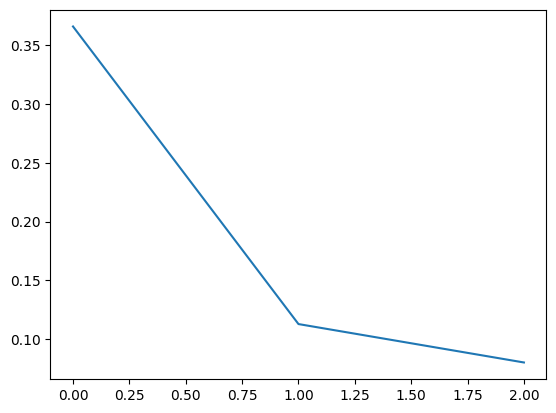

In [24]:
plt.plot(train_loss_set)

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [26]:
b_input_ids.shape

torch.Size([16, 256])

In [27]:
logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
logits

SequenceClassifierOutput(loss=None, logits=tensor([[-0.6833,  6.9538, -0.8689, -1.1717, -1.0818, -0.7637],
        [-1.6637, -1.7180,  6.6948, -1.9160, -2.2994, -1.8961],
        [-1.0564,  4.1658, -1.6999, -1.5707, -1.4272,  3.5267],
        [ 6.6188, -1.3588, -1.7036, -1.3558, -1.8396, -1.0008],
        [-1.5659, -0.9760, -1.0369, -0.6519, -1.5284,  5.7432],
        [-2.1699, -2.1072,  6.7575, -1.4923, -2.2768, -1.6106],
        [ 6.7102, -1.0495, -1.7205, -1.2574, -1.9448, -1.2719],
        [-1.9306, -1.8815,  6.7013, -1.8484, -1.9256, -1.9217],
        [-1.2188, -1.4989, -1.2128,  6.4547, -1.6548, -0.7014],
        [-2.0704, -2.1368,  6.6221, -2.0003, -2.0981, -1.1151],
        [-1.0849,  6.9879, -0.9444, -1.5881, -0.3065, -0.6805],
        [-0.5312, -1.3282, -2.1961, -1.5247,  6.9201, -1.4847],
        [-1.4292, -0.1255,  5.9249, -1.9667, -1.8283, -2.8142],
        [-1.5392, -1.7349, -0.8187,  6.4641, -1.4668, -1.0430],
        [-1.7290, -1.2124, -1.7571, -1.4019,  7.0493, -1.2291

In [28]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
df[['label','label_desc']].drop_duplicates(keep='first')

,label,label_desc
0,4,sadness
2,0,anger
3,3,love
6,5,surprise
7,1,fear
8,2,joy


In [31]:
## emotion labels
label2int = {
  "sadness": 4,
  "joy": 2,
  "anger": 0,
  "fear": 1,
  "surprise": 5,
    "love":3
}

In [32]:
 df_metrics['Predicted_class'].unique()

array([1, 2, 0, 5, 3, 4])

In [33]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

     sadness   1.000000  1.000000  1.000000         2
         joy   1.000000  1.000000  1.000000         3
       anger   1.000000  1.000000  1.000000         6
        fear   1.000000  1.000000  1.000000         2
    surprise   1.000000  1.000000  1.000000         2
        love   1.000000  1.000000  1.000000         1

    accuracy                       1.000000        16
   macro avg   1.000000  1.000000  1.000000        16
weighted avg   1.000000  1.000000  1.000000        16



In [34]:
df_metrics.shape

(16, 3)

In [35]:
text = "I'm very Happy"
input_ids_test = tokenizer.encode(text, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) 
attention_mask = [float(i>0) for i in input_ids_test]
att = torch.tensor([attention_mask])
t = torch.tensor([input_ids_test])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2837: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
att = att.to(model.device)
t = t.to(model.device)

In [37]:

# Set the batch size.  
batch_size = 16
# Create the DataLoader.
prediction_data = TensorDataset(t, att)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [38]:
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

In [39]:
logits 

tensor([[-1.3053, -1.9666,  6.4424, -1.8536, -1.6761, -2.3080]],
       device='cuda:0')

In [40]:
max_names = [torch.argmax(vals) for vals in logits]

In [41]:
max_names

[tensor(2, device='cuda:0')]

In [42]:
model_save_folder = 'model/'
tokenizer_save_folder = 'tokenizer/'

path_model = F'/kaggle/working/{model_save_folder}'
path_tokenizer = F'/kaggle/working/{tokenizer_save_folder}'

#create the dir

!mkdir -p {path_model}
!mkdir -p {path_tokenizer}

## Now let's save our model and tokenizer to a directory
model.save_pretrained(path_model)
tokenizer.save_pretrained(path_tokenizer)

model_save_name = 'fineTuneModel.pt'
path = path_model = F'/kaggle/working/{model_save_folder}/{model_save_name}'
torch.save(model.state_dict(),path);

In [47]:
!zip -r model.zip 'model'

  adding: model/ (stored 0%)
  adding: model/fineTuneModel.pt (deflated 7%)
  adding: model/config.json (deflated 54%)
  adding: model/model.safetensors (deflated 7%)


In [48]:
!zip -r tokenizer.zip 'tokenizer'

  adding: tokenizer/ (stored 0%)
  adding: tokenizer/tokenizer_config.json (deflated 75%)
  adding: tokenizer/special_tokens_map.json (deflated 42%)
  adding: tokenizer/vocab.txt (deflated 53%)


In [49]:
text = "I can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake"
input_ids_test = tokenizer.encode(text, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) 
attention_mask = [float(i>0) for i in input_ids_test]
att = torch.tensor([attention_mask])
t = torch.tensor([input_ids_test])

In [51]:
att = att.to(model.device)
t = t.to(model.device)

In [52]:
# Set the batch size.  
batch_size = 16
# Create the DataLoader.
prediction_data = TensorDataset(t, att)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [53]:
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

In [54]:
logits 

tensor([[-1.9852, -1.2082, -1.7020, -1.2262,  6.9261, -1.1565]],
       device='cuda:0')

In [55]:
max_names = [torch.argmax(vals) for vals in logits]

In [57]:
list(max_names)

[tensor(4, device='cuda:0')]